# Representation Analysis

In [1]:
import torch
import timm
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter
from functools import partial
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from src.models.components.cl_vs_mim.utils import subsample

In [2]:
import torch

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.7.0.dev20250122+cu126 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x732eda56eb60> 
Device name: NVIDIA GeForce RTX 4060 Ti


In [3]:

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = "~/development/datasets/imagenette2-160"

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=64,
)

## Load the Models

In [4]:
def load_moco():
    import src.models.components.cl_vs_mim.moco as moco
    from src.models.components.cl_vs_mim.moco  import load_state_dict
    from src.models.components.cl_vs_mim.utils import download
    path = "../../artifacts/moco_vit_b.pt"  #@param {type:"string"}
    url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}

    download(url, path, force=False)  # download checkpoints

    model = moco.vit_base()
    model = model.cuda()
    model = model.eval()

    state_dict = load_state_dict(path)
    _ = model.load_state_dict(state_dict, strict=False)
    return model

In [5]:
# SimMIM 
def load_simmmim():
    import src.models.components.cl_vs_mim.simmim as simmim
    from src.models.components.cl_vs_mim.simmim import load_state_dict
    path = "../../artifacts/simmim_vit_b.pth"  #@param {type:"string"}
    model = simmim.vit_base("../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml")
    model = model.cuda()
    model = model.eval()

    state_dict = load_state_dict(path)
    _ = model.load_state_dict(state_dict, strict=False)
    return model

In [6]:
def load_part():
    from functools import partial
    from src.models.part_vit_module import PARTViTModule

    path = "../../artifacts/model-ukjrb3lq:v0/epoch=41-step=52584.ckpt"  #@param {type:"string"}
    # reassign src.models.components.part_utils to src.models.components.utils.part_utils
    import sys
    sys.modules['src.models.components.part_utils'] = sys.modules['src.models.components.utils.part_utils']
    back = PARTViTModule.load_from_checkpoint(path, strict=False).net.backbone
    return back.cuda().eval()

In [7]:
def load_dora():
    model = torch.hub.load("dgcnz/DoRA_ICLR24", model="vit_small_patch16_224_dora_wt_venice_ep100")
    model = model.cuda()
    model = model.eval()
    return model

In [8]:
def load_part_v1(ckpt_path, dir_name):
    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace])
    ckpt = torch.load(ckpt_path, weights_only=True)
    kwargs = {
            "num_classes": ckpt['args'].nb_classes,
            "drop_rate": ckpt['args'].drop,
            "drop_path_rate": ckpt['args'].drop_path,
            # "drop_block_rate": None,
            "mask_prob": ckpt['args'].mask_prob,
            "pretrain": ckpt['args'].pretrain,
            "linear_probe": ckpt['args'].linear_probe,
            "global_pool": ckpt['args'].global_pool,
            "use_pe": ckpt['args'].use_pe,
            "use_ce": ckpt['args'].use_ce,
            "with_replacement": ckpt['args'].with_replacement,
            "num_pairs": ckpt['args'].num_pairs,
            "ce_op": ckpt['args'].ce_op,
            "loss": ckpt['args'].loss,
            "head_type": ckpt['args'].head_type,
            "column_embedding": ckpt['args'].column_embedding,
            "num_channels": 2,
            "debug_pairwise_mlp": ckpt['args'].debug_pairwise_mlp,
            "debug_cross_attention": ckpt['args'].debug_cross_attention,
            "cross_attention_query_type": ckpt['args'].cross_attention_query_type,
    }
    # dir_name = "../../../ogPART"
    model = torch.hub.load(dir_name, model="part_base_patch16_224", source='local', force_reload = True, **kwargs)
    model.load_state_dict(ckpt["model"])
    return model.eval().cuda()

In [9]:
def load_droppos():
    ckpt_path = "../../artifacts/DropPos_pretrain_vit_base_patch16.pth"
    ckpt = torch.load(ckpt_path)
    # state_dict = ckpt
    checkpoint_model = {k.replace("module.", ""): v for k, v in ckpt.items()}
    model = timm.create_model("vit_base_patch16_224.mae", pretrained=False)
    model.load_state_dict(checkpoint_model, strict=False)
    return model.cuda().eval()

In [10]:
def load_mae():
    return timm.create_model('vit_base_patch16_224.mae', pretrained=True).cuda().eval()

In [11]:
def load_dino():
    return timm.create_model('vit_base_patch16_224.dino', pretrained=True).cuda().eval()

def load_dinov2():
    return timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True, img_size=224, patch_size=16).cuda().eval()

## Fourier Analysis

Running dora


Using cache found in /home/dgcnz/.cache/torch/hub/dgcnz_DoRA_ICLR24_main


Take key teacher in provided checkpoint dict
Pretrained weights found at vit_small_patch16_224.dora.wt_venice.ep100.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


torch.Size([25, 7])
Running PARTv1
torch.Size([25, 7])
Running PARTv1_ft
torch.Size([25, 7])
Running DropPos
torch.Size([25, 7])
Running MoCo


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/torch/functional.py:540: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4311.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([25, 7])
Running SimMIM
=> merge config from ../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml
torch.Size([25, 7])
Running PARTv2


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


torch.Size([25, 7])
Running MAE


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.mae)
INFO:timm.models._hub:[timm/vit_base_patch16_224.mae] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


torch.Size([25, 7])
Running DINO


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.dino)
INFO:timm.models._hub:[timm/vit_base_patch16_224.dino] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


torch.Size([25, 7])


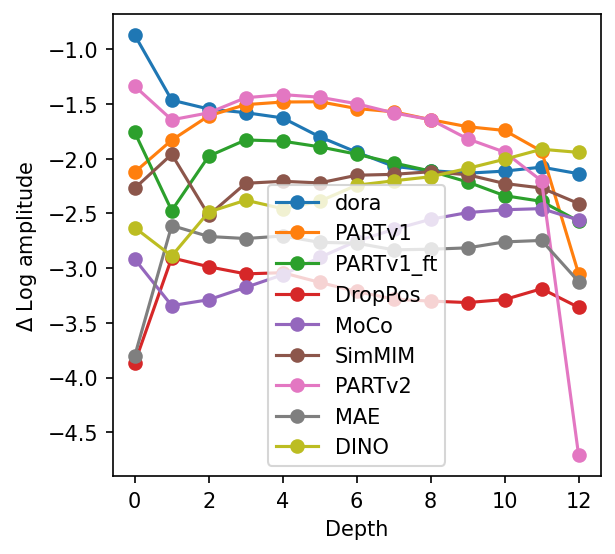

In [13]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import logging


def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
models = {
    "dora": load_dora,
    "PARTv1": partial(load_part_v1, "../../artifacts/tasks_2/9u72ktsg6k/artifacts/checkpoint_epoch_200.pth",  "../../../ogPART"),
    "PARTv1_ft": partial(load_part_v1, "../../artifacts/tasks_2/9u72ktsg6k/artifacts/checkpoint_ft_epoch_200.pth",  "../../../ogPART"),
    "DropPos": load_droppos,
    "MoCo": load_moco,
    "SimMIM": load_simmmim,
    "PARTv2": load_part,
    "MAE": load_mae,
    "DINO": load_dino,
    # "DINOv2": load_dinov2,
}
from src.utils.analysis.clmim_hook import ActivationCache

for label, loader in models.items():
    print(f"Running {label}")
    model = loader()
    head_name = "clf" if label == "PARTv1_ft" else "head"
    act = ActivationCache(head_name)
    # act.logger.setLevel(logging.DEBUG)
    act.hook(model)
    fourier_latents = AverageMeter()
    for i, (xs, ys) in enumerate(dataset_test):
        with torch.no_grad():
            xs = xs.cuda()
            _ = model(xs)

        zs = act.get_zs()
        zs = zs[:-1] # skips model output

        # if model has cls token remove it
        if model.cls_token is not None:
            latents = [z[:,1:,:] for z in zs]
        else:
            latents = [z for z in zs]
        _fourier_latents = torch.stack(get_fourier_latents(latents))
        fourier_latents.update(_fourier_latents)

        if i > -1:
            break

    print(fourier_latents.avg.shape)       
    fourier_latents = fourier_latents.avg
    ax.plot(range(13), fourier_latents[:,-1][::2], marker="o", label=label)

ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
# ax.set_ylim(top=-3, bottom=-3.5)
ax.legend()
plt.show()


## Toekn-level t-SNE Visualization

/tmp/ipykernel_40720/1407869445.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")):
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


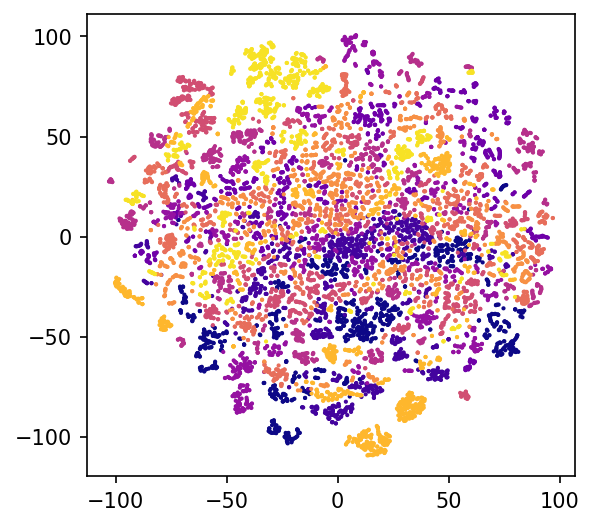

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")): 
    latents = zs[depth]
    latents = latents[:,1:,:]  # drop cls
    latents = rearrange(latents, "b n c -> (b n) c",)
    latents = latents.cpu()

    reducer = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random', n_iter=1000)
    embedded = reducer.fit_transform(latents)
    
    labels = ys 
    labels = np.array([[label] * 196 for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=1)
    
#@markdown Execute this cell to visualize token-level representations by using t-SNE. Note that we visualize 3,528 tokens (196 tokens×18 images) from the representations. 
#@markdown 
#@markdown The tokens of MoCo form a cluster for each image, while those of SimMIM are intermingled. This aligns with the finding that, compared to SimMIM, MoCo is linearly separable. The colors represent three different classes.

model_option = "moco"  #@param ["moco", "simmim"]
depth = 10  #@param {type:"slider", min:0, max:11, step:1}
if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

xs, ys = next(iter(dataset_test))
with torch.no_grad():
    xs = xs.cuda()
    _, zs, _, _ = model(xs)
    zs = zs[:-1]

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
visualize_token_tsne(ax, zs, depth=depth, ys=ys)  # coloring at the image level